(sec:std-fem-adr)=
## Challenges for standard finite element discretizations of the ADR problem

In this section, we have a look at the numerical challenges we encounter
when we try to discretize advection-dominant ADR problems with
a standard finite element method.   

(ssec:example-boudary-layer-ana)=
### Example 1: Solution with an exponential boundary layer

\begin{equation}
\left\lbrace
\begin{aligned}
-\Delta u &= f  \ \text{in} \ \Omega\\
u &= 0 \ \text{on}\ \partial\Omega.\\
\end{aligned}
\right.
\end{equation}

The function $u_{\epsilon} = x\dfrac{1-e^{(y-1)/\epsilon}}{1-e^{-2/\epsilon}}$ 
solves the PDE

\begin{align*}
-\epsilon \Delta u_{\epsilon} + \boldsymbol{b}\cdot \nabla u_{\epsilon} = f \quad \text{in } \Omega
\end{align*}

with domain $\Omega = [-1,1]^2$, velocity field $\boldsymbol{b} = (0,1)$, right-hand side $f=0$, and Dirichlet boundary conditions given by $u_\epsilon$. 
This function is a typical example
of a solution which exhibits an exponential boundary layer at the outflow boundary. The width of this boundary layer is $\approx \mathcal{O}(\epsilon)$.
Now plot the solution for various $\epsilon$,, e.g. $\epsilon = 1, 10^{-1}, 10^{-3}, 10^{-5}$:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def plot2D(X, Y, Z, title=""):
    # Define a new figure with given size an
    fig = plt.figure(figsize=(8, 6), dpi=100)
    # ax = fig.gca(projection='3d')
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, Z,             
                            rstride=1, cstride=1, # Sampling rates for the x and y input data
                            cmap=cm.plasma)      # Use the colormap plasma
    
    # Set initial view angle
    ax.view_init(30, 225)
   
 
    # Set labels and show figure
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u(x,y)$')
    ax.set_title(title)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.show()

In [2]:
# Example of solution with boundary layer
def u_ex(x, y, eps):
    return x*(1-np.exp((y-1)/eps))/(1-np.exp(-2/eps))
              
# Define subdivions in each direction
n = 50

# To define the grid we use "linspace" in each direction ...
xi = np.linspace(-1,1,n+1)
yi = np.linspace(-1,1,n+1)

x,y = np.meshgrid(xi,yi,sparse=True)

# Evaluate u on the grid. The output will be a 2 dimensional array 
# where U_ex_grid[i,j] = u_ex(x_i, y_j)
eps = 1e-3
U_ex_grid = u_ex(x,y, eps)

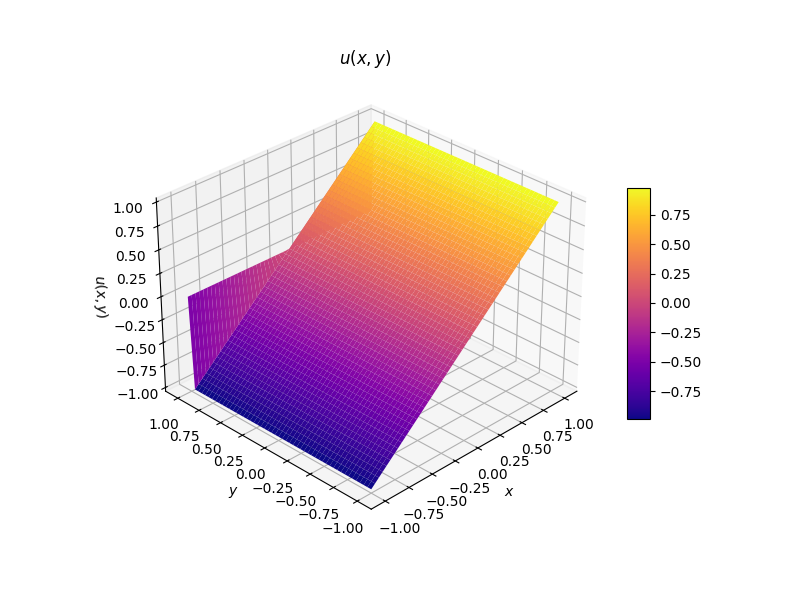

In [3]:
%matplotlib widget
plot2D(x, y, U_ex_grid, title="$u(x,y)$")

(ssec:example-boudary-layer-num)=
### Example 2: Trying to solve the previous example with a standard finite element method

Now we illustrate what happens if you try to solve the example above with a standard finite element method, where we seek $u_h \in V_{h,g} = \PP^k_c(\mcT_h)
\cap H^1_g(\Omega)$ 
such that $\forall v \in V_{h,0}$:

$$
a(u_h, v) := \epsilon(\nabla u_h, \nabla v)_{\Omega} + (b \cdot \nabla u_h, v_h)_{\Omega} + (c u_h, v_h)_{\Omega} = (f,v)_{\Omega} =: l(v)
$$

At the same time we use this example to recap the basic syntax of the finite element library [ngsolve](https://ngsolve.org), which has a large number of [Jupyter tutorials](https://ngsolve.org/docu/v6.2.2008/i-tutorials/index.html#).
The code below is basically compiled from 
[unit-1.1-poisson](https://ngsolve.org/docu/v6.2.2008/i-tutorials/unit-1.1-poisson/poisson.html) (solving Poisson with homogeneous Dirichlet b.c),
[unit-1.2-coefficient](https://ngsolve.org/docu/v6.2.2008/i-tutorials/unit-1.2-coefficient/coefficientfunction.html) (using coefficient functions to define $\bfb$), and
[unit-1.3-dirichlet](https://ngsolve.org/docu/v6.2.2008/i-tutorials/unit-1.3-dirichlet/dirichlet.html) (implemementation of non-homogeneous Dirichlet b.c.).

We will (try to) solve the problem for $\epsilon = 10^{-3}$.

First, we start by importing the necessary modules for ngsolve (the finite element module)
and the Opencascade ```occ``` submodule which is part of the ```netgen``` module for mesh generation.

In [4]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *

Note that if you want to implement your code in pure Python script,
then you would rather import the old gui interface
```python
from netgen import gui
```
Also, to start up the python file with the netgen gui, you have to
execute the python file in the terminal via
```
netgen <PYTHONFILE.py>
```
rather then just typing `python <PYTHONFILE.py>`.

The next block generate first a domain description and then a mesh (unstructured) for
the doman $\Omega = [-1,1]^2$ with a given $h_{\mathrm{max}}$.

Note that for the unit square domain, there exists a shortcut for the domain description and you can simply write 
```python 
from ngsolve import *
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
```

In [5]:
shape = Rectangle(2,2).Face().Move((-1,-1, 0))
shape.edges.name="rectangle"
maxh=0.2
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=maxh))
print(f"Boundary domains: {mesh.GetBoundaries()}")
Draw(mesh)

Boundary domains: ('rectangle', 'rectangle', 'rectangle', 'rectangle')


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

Next, we define the exact solution ```u_ex``` as a *coefficient function* in NGSolve and plot it.

In [6]:
# Define exact solution 
u_ex = x*(1-exp((y-1)/eps))/(1-exp(-2/eps))
Draw(u_ex, mesh, name="u_ex")

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

We also plot the vector field $\boldsymbol{b}$.

In [7]:
# Define coefficients for PDE and exact solution
b = CoefficientFunction((0,1))
Draw(b, mesh, "b", vectors=True)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

Let us redraw the function $u$ with different gui settings for ngsolve's webgui and with a different camera angle (defined
by the Euler rotation angles.)

In [8]:
# Gui settings
gui_settings = settings = { "subdivision" : 1, "deformation": 1.0, "Colormap" : { "ncolors" : 32 } }
Draw (u_ex, mesh, name="u_ex", settings=gui_settings, euler_angles=[-90,0,60])
help(Draw)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'subdivision': 1, 'deformati…

Help on function Draw in module netgen.webgui:

Draw(obj, *args, show=True, **kwargs)



Note that the boundary layer in the plot above does not seem to be as steep as in matplotlib plot we saw earlier, but this is just a numerical artefact. Since the mesh
we use is rather coarse, the underlying finite element space cannot resolve the boundary layer and and thus the transition of the interpolated function $\mathcal{I}_h(u_{\mathrm{ex}})$
happens basically in one layer of elements which is of course much wider than the actual boundary layer.

In the next step, we define the discrete trial and test functions and their respectives spaces we want to use.

In [9]:
# Define function spaces
p_order = 1
V = H1(mesh, order=p_order, dirichlet="rectangle")
u = V.TrialFunction()
v = V.TestFunction()
# Alternative shortcut
#u,v = V.TnT()

Now we can define bilinear form and linear form and assemble
them into a matrix and right-hand side vector, respectively.
Note that since $f=0$ in our case, we don't need
to assemble anything as the underlying vector associated
with ```l``` is initialized with a $0$ vector matching the dimension of the discrete function space. You can check
that easily by printing it
```python
print(l.vec)
```

In [10]:
a = BilinearForm(V) 
a += eps*grad(u)*grad(v)*dx
a += b*grad(u)*v*dx
a.Assemble()

l = LinearForm(V)
# If right-hand side is 0, we don't need to do anything
#l += 0*v*dx
# l.Assemble()

Note that we need to incorporate the inhomogeneous Dirichlet boundary data before we solve the linear system,
see [unit-1.3-dirichlet](https://ngsolve.org/docu/v6.2.2008/i-tutorials/unit-1.3-dirichlet/dirichlet.html) for a detailed explanation.

In [11]:
# Set boundary data
u_h = GridFunction(V)
u_h.Set(u_ex, BND)
Draw(u_h, name="u_D", settings=gui_settings)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'subdivision': 1, 'deformati…

BaseWebGuiScene

Finally, we can compute and plot the finite element solution to our ADR problem.

In [12]:
# Solve final system
r = l.vec.CreateVector()
r.data = l.vec - a.mat*u_h.vec
print(type(r.data))
u_h.vec.data += a.mat.Inverse(freedofs=V.FreeDofs())*r
Draw(u_h, name="u_h", settings=gui_settings)

<class 'ngsolve.la.BaseVector'>


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'subdivision': 1, 'deformati…

BaseWebGuiScene

Finally, we write out the solution as vtk file for visualization with paraview.

In [ ]:
vtk = VTKOutput(ma=mesh,coefs=[u_ex, u_h],
                names=["u_ex","u_h"],
                filename="adr-example",
                subdivision=1)
vtk.Do()

**Discussion: What did go wrong?**

Why does the finite element method perform so badly for the advective dominant ADR problem?
First, we recall that the exact solution exhibits a sharp transition layer which 
is much thinner than the last layer of the mesh elements touching the out flow boundary.

From the perspective of the finite element function, the solution appears to be 
almost discontinuous since the sharp transition can not be resolved sufficiently
as long as the mesh size is larger the the thickness of the boundary layer.
As a result and without further interventions, our continuous finite element with
suffer from large oscillations (similar to the Gibb's phenomena seen in 
Fourier series when approximating discontinuous functions), and moreover,
those oscillations are not only localized in a neighborhood of the boundary
layer, but they spread into the entire domain, completely destroying any
resemblance of the finite element solution with the exact solution.

But you might wonder, whether this contradicts {prf:ref}`Cea's lemma<ceas-lemma>`.
Didn't it state that the finite element solution is "almost" as good as the 
best approximation we can achieve in our given finite element space?
And the interpolated function $\mathcal{I}(u_{\mathrm{ex}})$ did look kind
like a reasonable approximation, except for the failure of resolving the
sharp boundary layer due to the relatively large mesh size?



The key to understand the situation lies in the word *quasi*-best approximation,
as {prf:ref}`Cea's lemma<ceas-lemma>` bounds the finite element error by the best approximation
error **multiplied with the ratio** $C_a/\alpha$ ! Let's have a look at 
the ratio in the case our ADR problem. Collecting the bounds from the previous 
section {ref}`sec-weak-formulation-adr`, we see that

$$
\dfrac{C_a}{\alpha}
 = \dfrac{\epsilon + \|\boldsymbol{b}\|_{L^{\infty}(\Omega)} C_P + \|c\|_{L^{\infty}(\Omega)} C_P^2  }{\epsilon}
= 1 + \dfrac{\|\boldsymbol{b}\|_{L^{\infty}(\Omega)} C_P}{\epsilon} 
+ \dfrac{\|c\|_{L^{\infty}(\Omega)} C_P^2}{\epsilon}  
$$
<!-- 
% = \dfrac{\epsilon + \|\boldsymbol{b}\|_{L^{\infty}(\Omega)} C_P + \|c\|_{L^{\infty}(\Omega)} C_P^2  }{\epsilon}
% \\
% = 1 + \dfrac{\|\boldsymbol{b}\|_{L^{\infty}(\Omega)}}{\epsilon} 
% + \dfrac{\|c\|_{L^{\infty}(\Omega)} C_P^2}{\epsilon}  
-->

For ADR problems, the number 

$$
\mathrm{Pe} = \dfrac{\|\boldsymbol{b} \|_{L^{\infty}(\Omega)}C_P}{\epsilon} 
$$(eq-Pe-num-def)

is called the [**Péclet number**](https://en.wikipedia.org/wiki/P%C3%A9clet_number), 
while

$$
\mathrm{Da} = \dfrac{\|c\|_{L^{\infty}(\Omega)} C_P^2}{\epsilon}
$$(eq:Da-num-def)

denotes the [**Damköhler number**](https://en.wikipedia.org/wiki/Damköhler_numbers).
Note that the Poincaré constant $C_P$ scales like $\mathrm{diam}(\Omega)$ and using the
proper physical units for reaction and diffusivity, we see that both numbers are
dimensionalless.

Now, for our example with the given domain, $\epsilon$ and $\boldsymbol{b}$, we
see that that the ADR problem is **advection-dominant** in the sense that $\mathrm{Pe} = 2000 \gg 1$.
An advection-dominant problem, the constant in Cea's lemma is of the size of the Péclet number 
which leads to an enormous amplification of the best-approximation error.

### A more refined a priori analysis

Does our standard finite element discretization of the ADR problems 
always struggle in the case of large Péclet numbers? The answer is: it 
depends, namely on the resolution of the mesh compared to the thickness
of the boundary layer. Let's investigate this in the next exercise.

````{exercise}
:label: ex-mesh-peclet

Set $\epsilon = 10^{-2}$ in the example above and recompute the finite element solution
for $h_{\mathrm{max}} \in \{0.25, 10^{-1}, 0.5\cdot 10^{-1}, 10^{-2}\}$.
How does the finite element solution behave? Can you relate it to the 
size of the (maximum of) so-called mesh Péclet number
```{math}
\mathrm{Pe}_h = \dfrac{\|\mathbf{b}\|_{L^{\infty}(\Omega)}}{h}
```
````

We can shed some light on the role of
```{prf:definition} Mesh Péclet number

$$
\mathrm{Pe}_T := \dfrac{\|\mathbf{b}\|_{L^{\infty}(T)}}{h_T},
\quad \mathrm{Pe}_h := \max_{T\in\mathcal{T}_h} \mathrm{Pe}_T
$$ (eq:Pe-local-def)

```

through a slightly more refined a priori error analysis.

As in the proof of {prf:ref}`Cea's lemma <ceas-lemma>`, we start by considering the erro $\|u -u_h\|$ and combine
coercivity, Galerkin's orthogonality and some slightly more careful use of Cauchy's inequalities to deduce that

```{math}
\epsilon \|\nabla(u - u_h)\|_{\Omega}^2
&\leqslant
a(u-u_h, u-u_h)
=
a(u-u_h, u-\pi_h u) 
\\
&=
\epsilon(\nabla (u-u_h), \nabla (u-\pi_h u))_{\Omega} + (\bfb\cdot\nabla (u-u_h), u-\pi_h u)_{\Omega} + (c (u-u_h) , u-\pi_h u)_{\Omega}
\\
&\leqslant 
\epsilon 
\|\nabla (u-u_h)\|_{\Omega}
\underbrace{
\|\nabla (u-\pi_h u)\|_{\Omega}
}_{\leqslant C h^k |u|_{k+1}}
+ 
\|\nabla(u-u_h)\|_{\Omega} 
\|\bfb\|_{L^{\infty}(\Omega)}
\underbrace{
\|u-\pi_h u \|_{\Omega}}_{\leqslant C h^{k+1} |u|_{k+1}}
\\
&\quad +
\|c\|_{L^{\infty}(\Omega)} 
\underbrace{\|u-u_h\|_{\Omega}}_{\leqslant C_P \|\nabla(u-u_h)\|_{\Omega}}
\|u-\pi_h u \|_{\Omega}
\\
&\leqslant
\epsilon 
\|\nabla (u-u_h)\|_{\Omega}
( h^{k}
+ 
\dfrac{\|\bfb\|_{L^{\infty}(\Omega)} h }{\epsilon} h^{k}
+
\dfrac{\|c\|_{L^{\infty}(\Omega)} C_P h}{\epsilon} h^{k} 
) C |u|_{k+1, \Omega}
```


